# Vision And Perception Project
Implementation of the paper " *Fighting Fake News: Image Splice Detection via Learned Self-Consistency* "

---


Website: https://minyoungg.github.io/selfconsistency/#slides_video

---

Students: 
Graziano Specchi, Cristiano Bellucci, Omar Bayoumi.

In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd ./drive/My\ Drive/vp_project

# Some imports
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os, random

# Library for create patches of an image
!pip install patchify
from patchify import patchify, unpatchify

# Library for reading the EXIF meta-data
!pip install exifread
import exifread
import json

Mounted at /content/drive
/content/drive/My Drive/vp_project


# Helpers

In [12]:
# Find left-right or top-bottom padding value
def paddingParameters(n):
  n1 = n//2
  n2 = n1
  if (n%2 == 1):
    n2+=1 
  return n1, n2

# Return array of the image. If it is and original image.
# Note that we need to flip it. Otherwise it is upside down.
def imRead(path):
  return np.flip(np.flip(np.array(Image.open(path)), 1),0)

# Return array of the image. If it is a filtered image.
def imReadFiltered(path):
  return np.array(Image.open(path))

# Return the patches array
def patches(image, size = 128):
  imageShape = np.shape(image)
  top, bottom = paddingParameters(size - (imageShape[0] % size))
  left, right = paddingParameters(size - (imageShape[1] % size))
  imageWithPadding = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
  patches = patchify(imageWithPadding, (size,size,3), step=size)
  return patches[:,:,0]

# Randomly select a patch into the image
def selectPatch(imagePath, patchSize, isFiltered):
  if (isFiltered):
    image = imReadFiltered(imagePath)
  else:
    image = imRead(imagePath)
  patchList = patches(image, patchSize)
  del image
  x = random.randrange(np.shape(patchList)[0])
  y = random.randrange(np.shape(patchList)[1])
  output = patchList[x][y]
  del patchList
  return output

# Model definition

In [13]:
# Parameters
patch_dim = 128
channels_imm = 3

# Inputs: Left and Right, for the Siamese Network

img_inputs_L = keras.Input(shape=(patch_dim, patch_dim, channels_imm))
img_inputs_R = keras.Input(shape=(patch_dim, patch_dim, channels_imm))
print(img_inputs_R.shape)

# Definition of the Neural Network

resnet50_A = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights="imagenet", input_tensor=None,
    input_shape=(patch_dim, patch_dim, channels_imm), pooling=None, classes=1000
)

# Since it is a Siamese Network, we feed the two images to the same instance of Resnet.
pre_feat_A = resnet50_A(img_inputs_L)
pre_feat_B = resnet50_A(img_inputs_R)

# Then we take the output of the last convolutional layer and we extract 4096 features.
glob_avg = keras.layers.GlobalAveragePooling2D(name='avg_pool_Out')
dense_top = keras.layers.Dense(4096, activation="relu",
                     name='predictions_Out')
glob_A = glob_avg(pre_feat_A)
feat_A = dense_top(glob_A)
glob_B = glob_avg(pre_feat_B)
feat_B = dense_top(glob_B)

# We concatenate the extracted features into a 8192 concatenated features vector.
concatenated_features = keras.layers.concatenate([feat_A,feat_B], name="concat")

# Fully connected part, as stated in the paper.
dense_4096 = keras.layers.Dense(4096, activation="relu")(concatenated_features)
dense_2048 = keras.layers.Dense(2048, activation="relu")(dense_4096)
dense_1024 = keras.layers.Dense(1024, activation="relu")(dense_2048)
dense_55 = keras.layers.Dense(55, activation="sigmoid")(dense_1024)

# Build the keras model
model = keras.Model(inputs=[img_inputs_L,img_inputs_R], outputs=dense_55, name="NN")

def reduce_and_sigm(label,out):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(label,out))

# Compile the model with the right loss function and optimizer
model.compile(
    loss=reduce_and_sigm,
    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
)

(None, 128, 128, 3)
94773248/94765736 [==============================] - 1s 0us/step


# Training loop definition
We train the model over the patches. During the training, we write the results like performances on the validation set, or the loss function value, accuracy, into a file *.txt* that is in our Google Drive folder, so that when we leave the notebook throghout the night, even if Colab shutdowns our notebook, we have always the saved data. 

In [9]:
# We use this path in order to save a file report
report_file_name = './modello_vecchio_sigmoid_crossentropy_e_4096_new/valid_report_third_training2.txt'
batch_for_handmade_validation = {}
# Function that trains the model, but also validate it.
def train_and_valid_model(index_train,model,input_L,input_R,np_labels,batchDim):
  from datetime import datetime
  input_L = np.array(input_L)
  input_R = np.array(input_R)
  np_labels = np.array(np_labels)
  print("input_L :",input_L.shape)
  print("input_R :",input_R.shape)
  print("np_labels :",np_labels.shape)
  
  input_L_preprocessed = tf.keras.applications.resnet50.preprocess_input(input_L)
  input_R_preprocessed = tf.keras.applications.resnet50.preprocess_input(input_R)
  #batch_for_handmade_validation["left"] = input_L_preprocessed
  #batch_for_handmade_validation["right"]= input_R_preprocessed
  #batch_for_handmade_validation["labels"] = np_labels
  if (index_train%5 == 0) : # Validation
    print("Salvando modello "+'./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello'+str(index_train)+"...")              
    model.save('./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello'+str(index_train))
    print("...Salvato modello "+'./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello'+str(index_train))
    print("VALIDATING....")

    prediction3 = model.predict([input_L_preprocessed,input_R_preprocessed])
    accuracy_list = []
    positive_precision_list = []
    negative_precision_list = []
    print(" [VALIDATION] iterating over a shape "+ str(prediction3.shape[0]) +" "+str(prediction3.shape[1]))
    for i_ in range(prediction3.shape[0]):
      true_negative = 0
      true_positive = 0
      false_negative = 0
      false_positive = 0
      instance_accuracy = 0
      azzeccate = 0
      for j_ in range(prediction3.shape[1]):
        current_predicted = 0
        if ( prediction3[i_][j_]>0.5 ) :
          current_predicted = 1 
        if ( np_labels[i_][j_] == current_predicted ):
          azzeccate += 1
        if ( np_labels[i_][j_]==0 and current_predicted==0 ):
          true_negative += 1
        if ( np_labels[i_][j_]==1 and current_predicted==0 ):
          false_negative += 1
        if ( np_labels[i_][j_]==0 and current_predicted==1 ):
          false_positive += 1
        if ( np_labels[i_][j_]==1 and current_predicted==1 ):
          true_positive += 1
          
      
      f = open(report_file_name, "a+")

      now = datetime.now()
      positive_precision = true_positive/(true_positive+false_positive)
      negative_precision = true_negative/(true_negative+false_negative)
      current_time = now.strftime("%H:%M:%S")
      f.write("\t["+current_time+" VALIDATION "+ str(index_train) +" SAMPLE "+str(i_)+"] "+"Azzeccate: "+str(azzeccate)+" Ratio:"+str((1.0*azzeccate)/(1.0*prediction3.shape[1]))+"\nTrue positive:"+str(1.0*true_positive)+"\nTrue negative:"+str(1.0*true_negative)+"\nFalse positive:"+str(1.0*false_positive)+"\nFalse negative:"+str(1.0*false_negative)+"\nPositive (1) Precision:"+str(1.0*positive_precision)+"\nNegative (0) Precision:"+str(1.0*negative_precision)+"\n")
      accuracy_list.append((1.0*azzeccate)/(prediction3.shape[1]*1.0))
      positive_precision_list.append(positive_precision)
      negative_precision_list.append(negative_precision)
      im = Image.fromarray(input_L[i_])
      plt.imshow(im)
      im.save("Left_image_"+str(i_)+".jpeg")
      im = Image.fromarray(input_R[i_])
      plt.imshow(im)
      im.save("Right_image_"+str(i_)+".jpeg")
    avg_valid_acc = 0
    sum_valid_acc = 0
    for elem in accuracy_list:
      sum_valid_acc += elem
    avg_valid_acc = (1.0*sum_valid_acc)/(1.0*len(accuracy_list))

    avg_valid_positive_precision = 0
    avg_valid_negative_precision = 0
    for elem in positive_precision_list:
      avg_valid_positive_precision+=elem
    avg_valid_positive_precision = (avg_valid_positive_precision*1.0)/(1.0*len(positive_precision_list))

    for elem in negative_precision_list:
      avg_valid_negative_precision+=elem
    avg_valid_negative_precision = (avg_valid_negative_precision*1.0)/(1.0*len(negative_precision_list))

    # Write the performances in the report file
    report_avg_string = "[VALIDATION AVG "+str(index_train)+"] "+str((1.0*avg_valid_acc))+"\nAVG_VALID_POS_PRECISION:"+str((1.0*avg_valid_positive_precision))+"\nAVG_VALID_NEG_PRECISION"+str((1.0*avg_valid_negative_precision))+"\n"
    f.write(report_avg_string)
    print(report_avg_string)
    f.close()
    print("[VALIDATION AVG "+str(index_train)+"] "+str((1.0*avg_valid_acc)))   

  # Training
  return model.fit([input_L_preprocessed,input_R_preprocessed],np_labels, batch_size=batchDim, epochs=1, validation_split=None)

history = []
# Entry point for the training and validation
def train_model(model, batchDim = 64, patchSize = 128):
  from datetime import datetime

  now = datetime.now()

  current_time = now.strftime("%H:%M:%S")
  f = open(report_file_name, "a+")
  f.write("\nStarted a new training at "+current_time+".\n")
  f.close()
  stop = False
  input = []
  exifBatches = []
  batch = []
  exifBatch = []
  index_train = 520

  # Training loop
  while (True):
    with open('./Exif/whitelistThreshold100.json') as wl:
      whitelist = json.load(wl)
    
    with open('./imagePerExifValue/imagePerExifValue100.json') as ipev100:
      imagePerExifValue = json.load(ipev100)
    
    with open('./filteredImages.json') as fl:
      filteredList = json.load(fl)

    with open('./filteredImagesExif.json') as fle:
      filteredListExif = json.load(fle)
    for exif, valueList in whitelist.items():
      for value_freq in valueList:
        value = value_freq[0]
        while (True):
          imagePathList = imagePerExifValue[exif][value]
          indexImagePath = random.randrange(len(imagePathList))
          randomfile = ""
          if (len(batch) < batchDim/2):
            randomfile = str(imagePathList[indexImagePath])
            imagePath = "./tmpDataset/" + randomfile
          else:
            while (True):
              randomfile = str(random.choice(os.listdir("./tmpDataset")))
              if (randomfile not in imagePathList):
                break
            imagePath = "./tmpDataset/" + randomfile
            
          isFiltered = False
          if (randomfile in filteredList):
            imageExif = filteredListExif[randomfile]
            isFiltered = True
#             print("filtrato: ", imageExif)
          else:
            image_rb = open(imagePath, 'rb')
            imageExif = exifread.process_file(image_rb)
            del image_rb
#           print(len(input), ": ", imagePath, " imageExif: ", imageExif.get(exif), " == ", value, "\nC'ho beccato ", len(batch), " volte!")
          if (imageExif.get(exif) != None and str(imageExif[exif]) == value and len(batch) < batchDim/2):
            batch.append(selectPatch(imagePath, patchSize, isFiltered))
            exifBatch.append(imageExif)
          if (imageExif.get(exif) != None and str(imageExif[exif]) != value and len(batch) >= batchDim/2):
            batch.append(selectPatch(imagePath, patchSize, isFiltered))
            exifBatch.append(imageExif)            
          if (len(batch) == batchDim):
            input.append(batch)
            exifBatches.append(exifBatch)
            batch = []
            exifBatch = []
            if (len(input) == 2):
              labels = []
              for i in range(len(exifBatches[0])):
                label = []
                for exif_label, valueList_label in whitelist.items(): 
                  noExif_a = "non presente"
                  noExif_b = "non presente"
                  if (exifBatches[0][i].get(exif_label) != None):
                    noExif_a = "presente"
                  if (exifBatches[1][i].get(exif_label) != None):
                    noExif_b = "presente"
                  if (noExif_a == "non presente" or noExif_b == "non presente"):
                    label.append(0.0)
                  else:
                    values_label = []
                    for value_freq_label in valueList_label:
                      values_label.append(value_freq_label[0])
                    noValue_a = "non presente"
                    noValue_b = "non presente"
                    if (str(exifBatches[0][i].get(exif_label)) in values_label):
                      noValue_a = str(exifBatches[0][i].get(exif_label))
                    if (str(exifBatches[1][i].get(exif_label)) in values_label):
                      noValue_b = str(exifBatches[1][i].get(exif_label))
                    if (noValue_a == "non presente" or noValue_b == "non presente"):
                      label.append(0.0)
                    else:
                      if (noValue_a == noValue_b):
                        label.append(1.0)
                      else:
                        label.append(0.0)
                        
                if (exifBatches[0][i].get("Gaussian filter") == exifBatches[1][i].get("Gaussian filter")):
                  label.append(1.0)
                else:
                  label.append(0.0)
                if (exifBatches[0][i].get("Image resize") == exifBatches[1][i].get("Image resize")):
                  label.append(1.0)
                else:
                  label.append(0.0)
                if (exifBatches[0][i].get("re_jpeg") == exifBatches[1][i].get("re_jpeg")):
                  label.append(1.0)
                else:
                  label.append(0.0)                
                labels.append(label)
              # print("len di input: ", len(input), "\nshape di batch A: ", np.shape(input[0]), "\nshape di batch B: ", np.shape(input[1]), "\nshape di label: ", np.shape(input[2]), "\nlabel: ", input[2])
              #RETE
              index_train += 1
              history.append(train_and_valid_model(index_train,model,input[0],input[1],labels,batchDim))
              input = []
              exifBatches = []
#               stop = True
#               break
        if (stop):
          break
      if (stop):
        break
    if (stop):
      break

#Model Summary

Model: "NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 4, 4, 2048)   23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
avg_pool_Out (GlobalAveragePool (None, 2048)         0           resnet50[0][0]                  

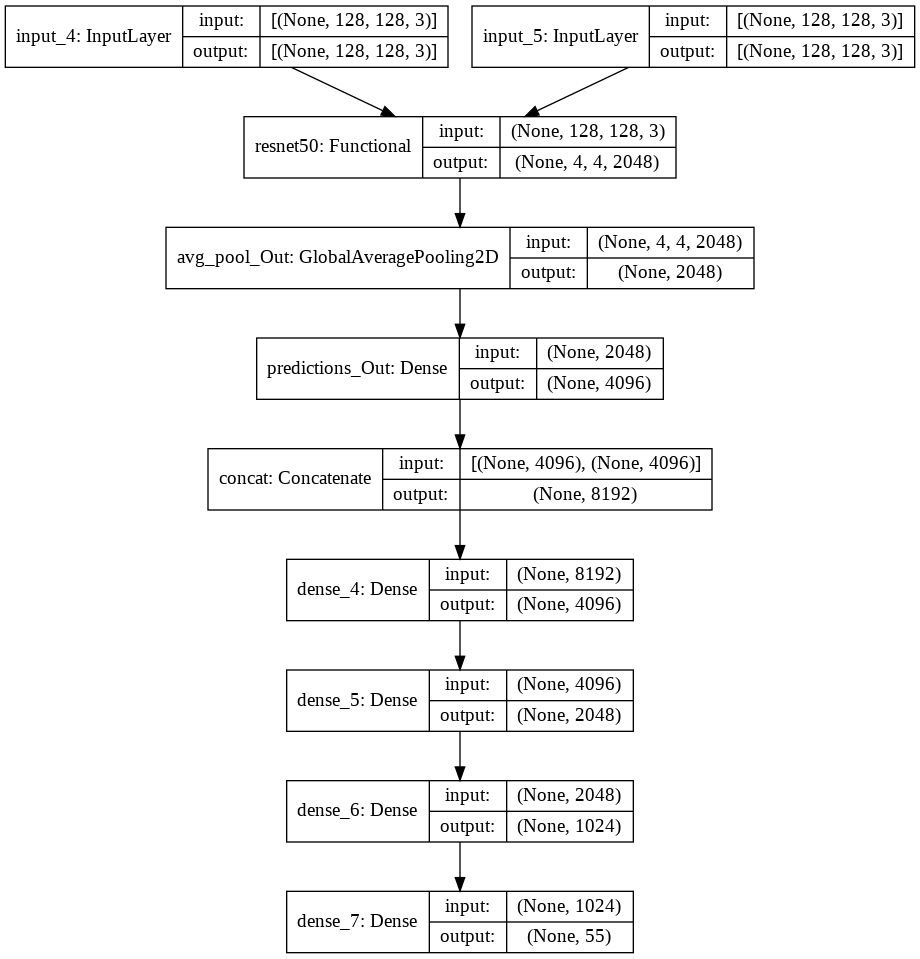

In [8]:
model.summary()
keras.utils.plot_model(model, "modello_vecchio_sigmoid_crossentropy.png", show_shapes=True)

In [6]:
# Load model already partially trained
model = keras.models.load_model('./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello510', compile=False)
model.compile(
    loss=tf.nn.sigmoid_cross_entropy_with_logits,
    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
)

In [10]:
train_model(model)

input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 481ms/step - loss: 0.6103
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 509ms/step - loss: 0.6167
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 486ms/step - loss: 0.6089
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 500ms/step - loss: 0.6121
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
Salvando modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello525...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello525/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello525
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 525] 0.9232954545454546
AVG_VALID_POS_PRECISION:0.9305746336996332
AVG_VALID_NEG_PRECISION0.9167273940826326

[VALIDATION AVG 525] 0.9232954545454546
1/1 [==============================] - 1s 503ms/step - loss: 0.6096
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 494ms/step - loss: 0.6078
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 479ms/step - loss: 0.6057
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 488ms/step - loss: 0.6085
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello530/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello530
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 530] 0.899147727272727
AVG_VALID_POS_PRECISION:0.9319196428571426
AVG_VALID_NEG_PRECISION0.879999678107641

[VALIDATION AVG 530] 0.899147727272727
1/1 [==============================] - 0s 476ms/step - loss: 0.6107
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 504ms/step - loss: 0.6055
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 491ms/step - loss: 0.6067
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 496ms/step - loss: 0.6111
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [=======

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello535/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello535
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 535] 0.8906249999999999
AVG_VALID_POS_PRECISION:0.9213396897220424
AVG_VALID_NEG_PRECISION0.8758666024120167

[VALIDATION AVG 535] 0.8906249999999999
1/1 [==============================] - 0s 480ms/step - loss: 0.6116
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 503ms/step - loss: 0.6071
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 503ms/step - loss: 0.6101
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 499ms/step - loss: 0.6187
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello540/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello540
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 540] 0.8954545454545451
AVG_VALID_POS_PRECISION:0.9464285714285711
AVG_VALID_NEG_PRECISION0.8773112757552205

[VALIDATION AVG 540] 0.8954545454545451
1/1 [==============================] - 0s 478ms/step - loss: 0.6055
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 499ms/step - loss: 0.6107
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 477ms/step - loss: 0.6106
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 522ms/step - loss: 0.6199
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello545/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello545
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 545] 0.8909090909090908
AVG_VALID_POS_PRECISION:0.9402901785714282
AVG_VALID_NEG_PRECISION0.8769996279761907

[VALIDATION AVG 545] 0.8909090909090908
1/1 [==============================] - 0s 471ms/step - loss: 0.6085
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 501ms/step - loss: 0.6123
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 490ms/step - loss: 0.6149
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 480ms/step - loss: 0.6048
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello550/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello550
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 550] 0.880397727272727
AVG_VALID_POS_PRECISION:0.9653087797619047
AVG_VALID_NEG_PRECISION0.8563063406760254

[VALIDATION AVG 550] 0.880397727272727
1/1 [==============================] - 0s 491ms/step - loss: 0.6088
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 497ms/step - loss: 0.6111
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 510ms/step - loss: 0.6127
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 495ms/step - loss: 0.6100
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [======

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello555/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello555
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 555] 0.8980113636363638
AVG_VALID_POS_PRECISION:0.9203869047619043
AVG_VALID_NEG_PRECISION0.8844093004049447

[VALIDATION AVG 555] 0.8980113636363638
1/1 [==============================] - 0s 494ms/step - loss: 0.6136
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 490ms/step - loss: 0.6166
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 474ms/step - loss: 0.6114
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 475ms/step - loss: 0.6079
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello560/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello560
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 560] 0.8982954545454545
AVG_VALID_POS_PRECISION:0.9397321428571425
AVG_VALID_NEG_PRECISION0.8809052148321451

[VALIDATION AVG 560] 0.8982954545454545
1/1 [==============================] - 1s 503ms/step - loss: 0.6129
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 478ms/step - loss: 0.6114
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 518ms/step - loss: 0.6126
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 475ms/step - loss: 0.6077
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello565/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello565
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 565] 0.9022727272727271
AVG_VALID_POS_PRECISION:0.9402803884711777
AVG_VALID_NEG_PRECISION0.8863038705065359

[VALIDATION AVG 565] 0.9022727272727271
1/1 [==============================] - 0s 494ms/step - loss: 0.6087
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 479ms/step - loss: 0.6061
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 509ms/step - loss: 0.6127
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 500ms/step - loss: 0.6118
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello570/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello570
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 570] 0.8997159090909089
AVG_VALID_POS_PRECISION:0.9580357142857138
AVG_VALID_NEG_PRECISION0.8794372957516339

[VALIDATION AVG 570] 0.8997159090909089
1/1 [==============================] - 0s 490ms/step - loss: 0.6117
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 491ms/step - loss: 0.6100
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 488ms/step - loss: 0.6089
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 1s 514ms/step - loss: 0.6056
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello575/assets
...Salvato modello ./modello_vecchio_sigmoid_crossentropy_e_4096_new/8_modello575
VALIDATING....
 [VALIDATION] iterating over a shape 64 55
[VALIDATION AVG 575] 0.9031249999999996
AVG_VALID_POS_PRECISION:0.9382440476190472
AVG_VALID_NEG_PRECISION0.8851530437756499

[VALIDATION AVG 575] 0.9031249999999996
1/1 [==============================] - 1s 1s/step - loss: 0.6093
input_L : (64, 128, 128, 3)
input_R : (64, 128, 128, 3)
np_labels : (64, 55)
1/1 [==============================] - 0s 484ms/step - loss: 0.6076


IndexError: ignored

Error in callback <function flush_figures at 0x7fbfc6c55050> (for post_execute):


KeyboardInterrupt: ignored

# Some tests by hands for visual inspection: 
# Left Column --> predicted
# Right Column --> ground truth

In [29]:
for i in range(len(testPred[4])):
  print(testPred[4][i].round(),batch_for_handmade_validation["labels"][4][i])


1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 1.0
1.0 1.0
1.0 1.0
0.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 1.0
1.0 1.0
1.0 1.0
0.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0


In [30]:
for i in range(len(testPred[1])):
  print(testPred[1][i].round(),batch_for_handmade_validation["labels"][1][i])


1.0 1.0
0.0 1.0
0.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0


In [34]:
patch_number = 14
for i in range(len(testPred[patch_number])):
  print(testPred[patch_number][i].round(),batch_for_handmade_validation["labels"][patch_number][i])


0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
0.0 1.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
